In [1024]:
# 12 - LONG READS
#
# This script takes the information in tagged_reads.csv and combines the reads into long reads. The script is based on 12_long_reads.ipynb
#
# INPUTS:
#   run_number
#   disease
#   tagged_reads.csv
# 
# OUTPUTS:
#   tagged_long_reads.csv

# Load modules

In [1136]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

# Set variables

In [1137]:
run_number="run1"
chrom="chr11"
dis="sca"

# Setup
chrom_dis=f"{chrom}_{dis}"
rootdir=f"/mnt/aretian/genomics/nanopore"
datadir=f"/mnt/aretian/genomics/nanopore/{run_number}"

# Parameters
expected_gap_fraction = 0.5

In [1138]:
print('')
print('----------------------------------------------------------------------')
# print(f'12 - CREATE LONG READS (__file__})')
print(f'12 - CREATE LONG READS)')
print(f"Run: {run}, disease: {dis}.")
print('')
print('')


----------------------------------------------------------------------
12 - CREATE LONG READS)
Run: 1, disease: sca.




# Load Data

In [1139]:
df = pd.read_csv(f'{datadir}/{run_number}_{chrom}_tagged_reads.csv')
original_columns = df.columns
df = df.rename(columns={'startpos':'orig_pos'})
shift = min(df['orig_pos'])
df['pos'] = df['orig_pos'] - shift
df['seq_len']= df['read'].apply(lambda x: len(x))
df['end_pos']=df['pos']+df['seq_len']-1
df['sample'] = df['samplename'].str[-1].astype(int)

# Helper functions

## Descriptive Statistics

In [1140]:
def create_bins(df):
    total_length = max(df['end_pos'])
    reads_0 = df[df['sample']==0]
    reads_1 = df[df['sample']==1]

    # Number of reads
    n_0=len(reads_0)
    n_1=len(reads_1)

    # Average length
    mean_length = df['seq_len'].mean()
    mean_length_0 = reads_0['seq_len'].mean()
    mean_length_1 = reads_1['seq_len'].mean()

    # Total bins
    expected_gap = mean_length*expected_gap_fraction
    bin_length = round(mean_length + expected_gap)
    n_bins_exact = total_length/bin_length 
    n_bins = round(n_bins_exact)

    # Bins in  person0
    n_long_reads_0 = n_0/n_bins
    # Bins in person1
    n_long_reads_1 = n_1/n_bins

    print(f"OPTIMAL BIN SIZE AND NUMBER")
    print("")
    print(f"Total length of region:     {total_length:,.0f}")
    print(f"Avg read length:               {mean_length:,.2f}")
    print(f"Avg read length + {expected_gap_fraction*100:,.0f}% padd:    {mean_length+expected_gap:,.2f}")
    print(f"Bin length:                    {bin_length:,.0f}")
    print(f"total_length/bin_length:           {n_bins_exact:,.2f}")
    print(f"Number of bins:                    {n_bins:,.2f} --> last bin is {'shorter' if (n_bins>n_bins_exact) else 'longer'}.")
    print("")
    print(f"ESTIMATED # OF LONG READS PER PERSON")
    print("")
    print(f"               Count       Avg Length    N of long reads ")
    print(f"person0        {n_0:,.0f}       {mean_length:,.0f}        {n_long_reads_0:,.0f}")   
    print(f"person1        {n_1:,.0f}       {mean_length_0:,.0f}        {n_long_reads_1:,.0f}")
    print(f"Full sample    {len(df):,.0f}       {mean_length_1:,.0f}        {n_long_reads_0 + n_long_reads_1:,.0f}")

    # Parameters
    bins = []

    last_bin_end = 0
    for i in range(int(np.floor(n_bins))):
        bin_start = last_bin_end + 1
        bin_end   = bin_start + bin_length - 1
        bins.append([bin_start, bin_end])
        last_bin_end = bin_end

    # Gap
    bin_agg_length = n_bins * bin_length
    gap = total_length - bin_agg_length
    print("")
    print(f"ADJUSTMENT FOR LAST BIN")
    print("")
    print(f"Total length:         {total_length:,.0f}")
    print(f"Bin aggregate length: {bin_agg_length:,.0f}")
    print(f"Difference:              {gap:,.0f}")

    # Last bin length
    last_bin_length = bin_length + gap
    print(f"Bin length:              {bin_length:,.0f}")
    print(f"Last bin length:         {last_bin_length:,.0f}")

    # Adjust last bin length
    bins[-1][1]=bins[-1][0]+last_bin_length-1
    
    return bins

## Assign reads to bins

In [1141]:
def assign_reads_to_bins(df, bins, selected_person):
# Returns person_reads with the 'bin' column of bin membership
    
    print("")
    print("Assigning reads to bins.")
    print(f"Selected person: person{selected_person}.")

    if   selected_person == 0:
        reads_0 = df[df['sample']==0]
        person_reads = reads_0.copy()
    elif selected_person == 1:
        reads_1 = df[df['sample']==1]
        person_reads = reads_1.copy()

    # Count empty bins
    empty_bins = 0
    empty_bins_list = []

    # Initialize bin column with empty lists
    person_reads['bin']=np.empty((len(person_reads), 0)).tolist()

    # Lambda function to append bin membership to list
    def append_bin(read, bin):
        read['bin'].append(bin)
        return read

    # Add bin membership column to person_reads df

    for n, bin in enumerate(bins):

        # Get reads in bin
        read_starts_inside = (person_reads['pos']    >bin[0]) & (person_reads['pos']    <bin[1])
        read_ends_inside   = (person_reads['end_pos']>bin[0]) & (person_reads['end_pos']<bin[1])
        read_covers        = (person_reads['pos']    <bin[0]) & (person_reads['end_pos']>bin[1])

        overlaps_bin = (read_starts_inside | read_ends_inside | read_covers)

        # Count empty bins
        if overlaps_bin.sum() == 0:
            empty_bins = empty_bins + 1
            empty_bins_list.append(n)
#             print(f'Empty bin: {n}')
            continue

        # Append bin number to bin column
        person_reads.loc[overlaps_bin].apply(lambda x: append_bin(x, n), axis=1)

    print(f"Done. Reads with no assigned bin: {person_reads['bin'].isna().sum()}")
    print(f"There are {empty_bins} empty bins: {empty_bins_list}")
    
    return person_reads

## Create long reads

In [1142]:
# mydf = pd.DataFrame({'boolean':[True, False], 'assigned':[True, False]})
# mydf

In [1143]:
# (mydf['boolean'] & ~mydf['assigned']).any()

In [1144]:
# mydf['boolean'].all()

In [1145]:
def create_long_reads(person_reads):
# Populated the person_reads dataframe with the long_read column
    
    print("")
    print("Creating long reads.")
    
    n_bins = max(person_reads['bin'].max())
    
    # List of bins to iterate over
    search_bins = list(range(n_bins))

    # Initialize long read membership
    person_reads['long_read'] = np.nan
    # Track reads that are already assigned
    person_reads['assigned'] = False

    long_read_number = 0

    n_unassigned = len(person_reads)
    
    while n_unassigned > 0:
        # While there are unassigned reads

        n_unassigned = len(person_reads) - person_reads['assigned'].sum()
        progress = (1-n_unassigned/len(person_reads))*100

        for n in search_bins:
        # Run bin loop assigning reads

            # Get reads in bin
            bin_reads_boolean = person_reads.apply(lambda x: n in x['bin'], axis=1)

            # If all reads in bin have been assigned, skip and ignore bin in the future
            if (bin_reads_boolean & ~person_reads['assigned']).any() == False:
                search_bins.remove(n)
                continue
                
            print(f"\rLong read: {long_read_number:3.0f}. Bin: {n:3.0f}. Unassigned: {n_unassigned:5.0f}. Progress: {progress:3.0f}%", end="", flush=True)
            
            # Get reads in bin that are not assigned
            bin_reads = person_reads.loc[bin_reads_boolean & ~person_reads['assigned']]

            # Get first read, assign it to long read
            selected_index = bin_reads.index[0]
            person_reads.loc[selected_index, 'long_read'] = long_read_number

            # Record assignment
            person_reads.loc[selected_index, 'assigned'] = True

        # Go to the next long read
        long_read_number += 1

    print("")
    print("Done.")
    
    return person_reads

## Plot Long reads

In [1146]:
def plot_long_reads(person_reads):
    # Get effective number of long reads
    n_long_reads = int(person_reads['long_read'].max() + 1)

    # long_read_binary = list(np.zeros(total_length))
    long_read_collection = []
    print("Identifying points to plot long reads.")
    print(f"Total number of long reads: {n_long_reads}")

    for long_read_n in range(n_long_reads):
        long_read_binary = []

        print(f"\rProcessing long read: {long_read_n}", end="", flush=True)

        selected_long = person_reads.loc[person_reads['long_read']==long_read_n].copy()

        for point in range(0,total_length+1,10000):
            after_start =  selected_long['pos']< point
            before_end  =  point < selected_long['end_pos']
            is_in_read  = (after_start & before_end).any()

            value_to_append = 1 if is_in_read else np.nan
            long_read_binary.append(value_to_append)

        long_read_collection.append(long_read_binary)

    #     if is_in_read:
    #         long_read_binary[point]=1

    print("")
    print("Plotting.")
    # print(f"Length of read to plot: {len(long_read_binary)}")

    plt.subplots(figsize=(20,10))
    x = range(len(long_read_collection[0]))

    # for i in range(len(long_read_collection)):
    for i in range(100):
        long_read_binary = [x * (i+1) for x in long_read_collection[i]]
        plt.scatter(x, long_read_binary)

# Implementation

## Create Bins

In [1147]:
bins = create_bins(df)

OPTIMAL BIN SIZE AND NUMBER

Total length of region:     4,080,268
Avg read length:               37,296.16
Avg read length + 50% padd:    55,944.25
Bin length:                    55,944
total_length/bin_length:           72.93
Number of bins:                    73.00 --> last bin is shorter.

ESTIMATED # OF LONG READS PER PERSON

               Count       Avg Length    N of long reads 
person0        4,494       37,296        62
person1        1,548       36,921        21
Full sample    6,042       38,386        83

ADJUSTMENT FOR LAST BIN

Total length:         4,080,268
Bin aggregate length: 4,083,912
Difference:              -3,644
Bin length:              55,944
Last bin length:         52,300


## Assign reads to bins and create long reads

In [1148]:
selected_person = 0
person_reads0 = assign_reads_to_bins(df, bins, selected_person)
person_reads0 = create_long_reads(person_reads0)

selected_person = 1
person_reads1 = assign_reads_to_bins(df, bins, selected_person)
person_reads1 = create_long_reads(person_reads1)

print("")
print(f"Person 0 long reads: {person_reads0['long_read'].max():,.0f}")
print(f"Person 1 long reads: {person_reads1['long_read'].max():,.0f}")

## Concatenate output

In [1152]:
person_reads = pd.concat([person_reads0, person_reads1])

## Plot

Identifying points to plot long reads.
Total number of long reads: 370
Processing long read: 369
Plotting.


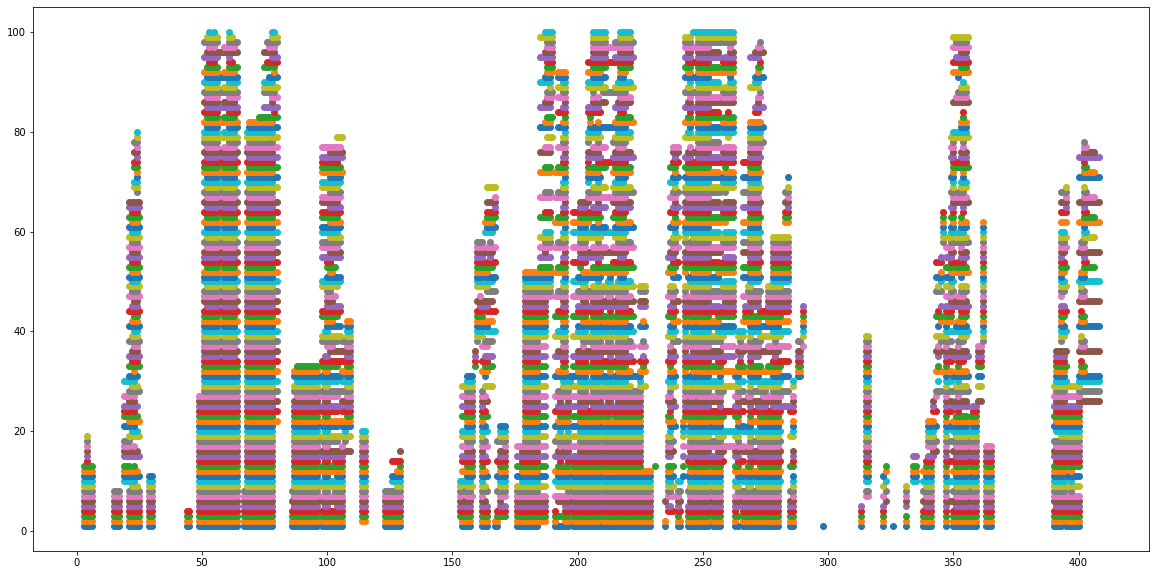

In [1153]:
plot_long_reads(person_reads0)

Identifying points to plot long reads.
Total number of long reads: 119
Processing long read: 118
Plotting.


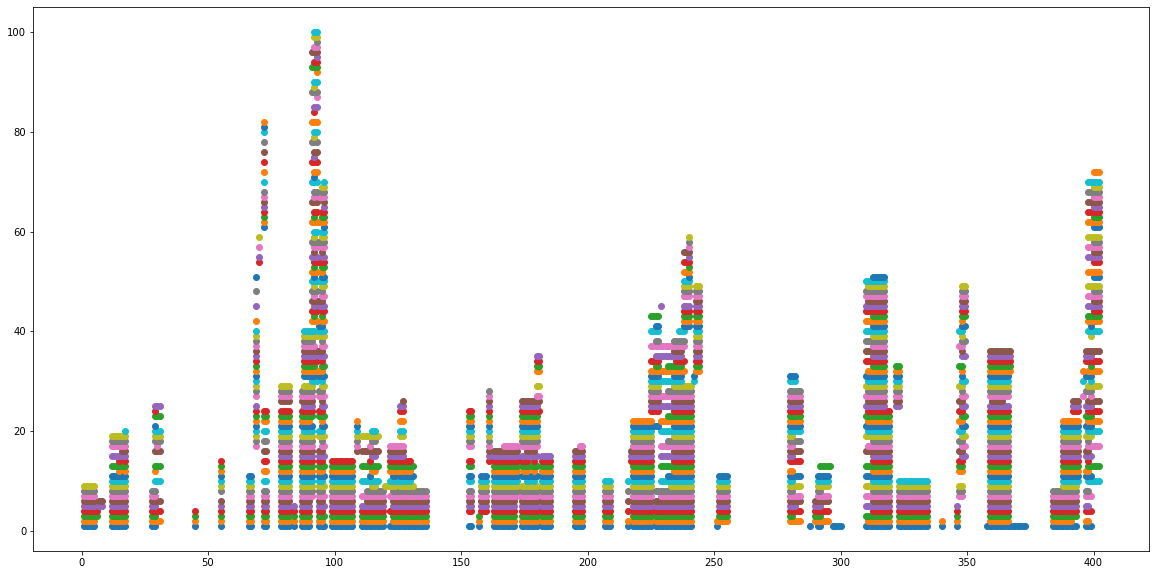

In [1154]:
plot_long_reads(person_reads1)

# Create output file

In [1155]:
# Rename and keep columns as original file
person_reads_out = person_reads.copy()

# Create long read ID
person_reads_out['long_read_id'] = person_reads_out['samplename'] + '-' + person_reads_out['long_read'].astype(int).astype(str)

# Replace new read ID
person_reads_out = person_reads_out.drop(columns=['read_id'])
person_reads_out = person_reads_out.rename(columns={'long_read_id':'read_id'})

# Rename columns as original
person_reads_out = person_reads_out.rename(columns={'orig_pos':'startpos'})
person_reads_out = person_reads_out[original_columns]

## Save

In [1157]:
person_reads_out.to_csv(f'{datadir}/{run_number}_{chrom}_long_tagged_reads.csv', index=None)
#           output.to_csv(f'{datadir}/{run_number}_{chrom}_person_full.txt', index=None, header=None, sep='\t')
# datadir,'/', run_number,'_',chr,'_tagged_reads.csv')